# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Write the problem in your own words here

In [34]:
#import libraries
import os
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
sns.set()


__author__ = "Anup C"
__email__ = "chanuprao@gmail.com"

In [3]:
os.chdir('F:\Data Science Dream Job\Portfolio Projects\Project_1_05192019')
os.getcwd()

'F:\\Data Science Dream Job\\Portfolio Projects\\Project_1_05192019'

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [4]:
test_features = pd.read_csv('test_features.csv')
train_features = pd.read_csv('train_features.csv')
train_salaries = pd.read_csv('train_salaries.csv')

### ---- 3 Clean the data ----

In [5]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
train_features.shape

(1000000, 8)

In [6]:
train_features.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
dtype: object

In [7]:
train_salaries.shape

(1000000, 2)

In [62]:
test_features.head(5)

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [291]:
raw_train_data = pd.merge(train_features,train_salaries, how = 'left', on = ['jobId'])
raw_train_data.head(5)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


## Keeping only the variables of interest

In [292]:
raw_train_data = raw_train_data.drop(['jobId','companyId'],axis = 1)
raw_train_data.describe(include='all')

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
count,1000000,1000000,1000000,1000000,1000000.000000,1000000.000000,1000000.000000
unique,8,5,9,7,NaN,NaN,NaN
top,SENIOR,HIGH_SCHOOL,NONE,WEB,NaN,NaN,NaN
freq,125886,236976,532355,143206,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,11.992386,49.529260,116.061818
std,NaN,NaN,NaN,NaN,7.212391,28.877733,38.717936
min,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,6.000000,25.000000,88.000000
50%,NaN,NaN,NaN,NaN,12.000000,50.000000,114.000000
75%,NaN,NaN,NaN,NaN,18.000000,75.000000,141.000000


In [256]:
raw_train_data['jobType'].value_counts()

SENIOR            125886
VICE_PRESIDENT    125235
MANAGER           125121
CTO               125046
JANITOR           124971
CEO               124778
JUNIOR            124594
CFO               124369
Name: jobType, dtype: int64

In [257]:
raw_train_data['degree'].value_counts()

HIGH_SCHOOL    236976
NONE           236854
BACHELORS      175495
DOCTORAL       175364
MASTERS        175311
Name: degree, dtype: int64

In [258]:
raw_train_data['major'].value_counts()

NONE           532355
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58596
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57801
Name: major, dtype: int64

In [306]:
raw_train_data['salary'].where(raw_train_data['jobType'] == 'MANAGER').mean()

115.36759616691043

In [315]:
raw_train_data['jobType'].where((raw_train_data['major'] == 'NONE') & (raw_train_data['degree'] == 'NONE')).value_counts()

JANITOR           62544
SENIOR            25117
MANAGER           25092
CEO               24898
CTO               24882
VICE_PRESIDENT    24825
JUNIOR            24782
CFO               24714
Name: jobType, dtype: int64

## Adding New Feature

In [317]:
def profile(df):
    if (df['major'] == 'NONE' and df['degree'] == 'NONE') or df['salary'] < 70:
        return 'Drop Out'
    if df['degree'] == 'DOCTORAL' and (df['jobType'] == 'CTO' or df['jobType'] == 'CFO' or df['jobType'] == 'CEO' or \
    df['jobType'] == 'VICE_PRESIDENT') or df['salary'] > 200:
        return 'Executives'
    if df['jobType'] == 'SENIOR' or df['jobType'] == 'MANAGER' or df['salary'] > 100 and \
    (df['degree'] == 'DOCTORAL' or df['degree'] == 'MASTERS' or df['degree'] == 'BACHELORS'):
        return 'Management'
    if df['jobType'] == 'JUNIOR' and df['salary'] < 100 and \
    (df['degree'] == 'HIGH_SCHOOL' or df['degree'] == 'BACHELORS'):
        return 'Freshers'
    else:
        return 'Average Employee'

In [341]:
def experience_buckets(df):
    if df['yearsExperience'] > 0 and df['yearsExperience'] <= 5:
        return '0-5'
    if df['yearsExperience'] > 5 and df['yearsExperience'] <= 10:
        return '5-10'
    if df['yearsExperience'] > 10 and df['yearsExperience'] <= 15:
        return '10-15'
    if df['yearsExperience'] > 15 and df['yearsExperience'] <= 20:
        return '15-20'
    else:
        return '>20'        

In [318]:
raw_train_data['profile'] = raw_train_data.apply(profile, axis=1)
raw_train_data.profile.value_counts()

Management          395740
Drop Out            296513
Average Employee    173147
Executives          113383
Freshers             21217
Name: profile, dtype: int64

In [342]:
raw_train_data['experience_buckets'] = raw_train_data.apply(experience_buckets, axis=1)
raw_train_data.experience_buckets.value_counts()

0-5      200550
5-10     200527
15-20    199882
>20      199660
10-15    199381
Name: experience_buckets, dtype: int64

In [259]:
raw_train_data['industry'].value_counts()

WEB          143206
AUTO         142943
FINANCE      142867
EDUCATION    142819
OIL          142771
HEALTH       142755
SERVICE      142639
Name: industry, dtype: int64

In [260]:
raw_train_data['yearsExperience'].value_counts()

15    40312
1     40265
9     40235
3     40191
22    40187
8     40118
6     40095
18    40089
17    40072
7     40047
2     40045
4     40036
10    40032
23    40015
5     40013
20    39988
11    39949
16    39873
19    39860
24    39860
0     39839
14    39827
13    39826
21    39759
12    39467
Name: yearsExperience, dtype: int64

In [262]:
raw_train_data['milesFromMetropolis'].nunique()

100

In [343]:
nodup_train_data = raw_train_data.drop_duplicates()
nodup_train_data.dtypes

jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
profile                object
experience_buckets     object
dtype: object

In [267]:
# checking for NULL values across all fields
nodup_train_data.isnull().sum()

jobType                0
degree                 0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

In [344]:
train_data = nodup_train_data.copy()
train_data['salary'] = train_data['salary'].replace(',', '').astype(int)
train_data = train_data.loc[train_data['salary'] > 0]
train_data.shape

(989185, 9)

### ---- 4 Explore the data (EDA) ----

In [96]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

In [206]:
train_data.columns

Index(['jobType', 'degree', 'major', 'industry', 'yearsExperience',
       'milesFromMetropolis', 'salary'],
      dtype='object')

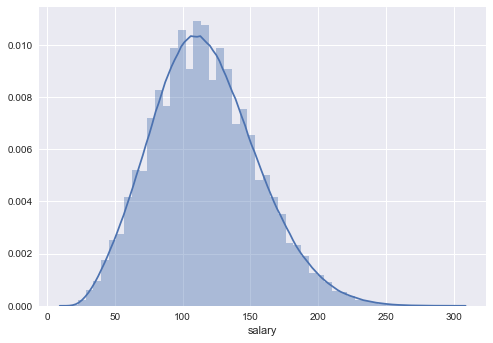

In [98]:
sns.distplot(train_data['salary'])
plt.show()

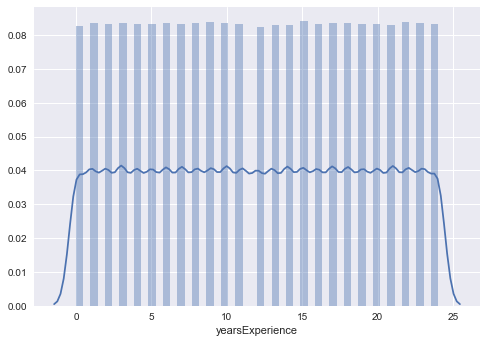

In [99]:
sns.distplot(train_data['yearsExperience'])
plt.show()

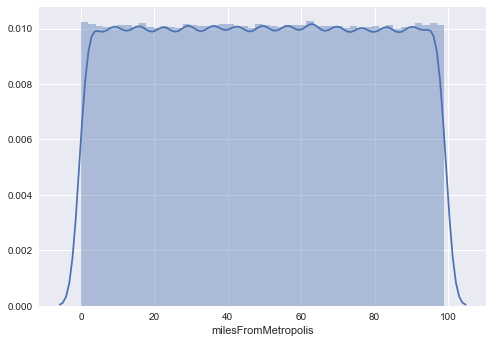

In [100]:
sns.distplot(train_data['milesFromMetropolis'])
plt.show()

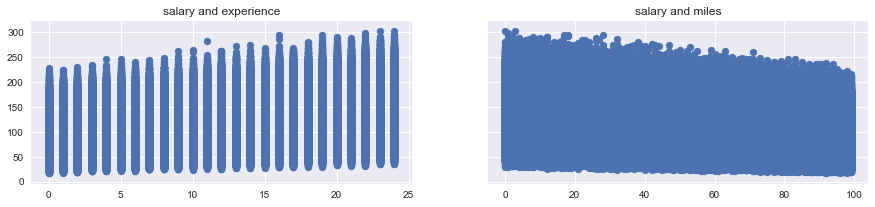

In [101]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(15,3))
ax1.scatter(train_data['yearsExperience'],train_data['salary'])
ax1.set_title('salary and experience')
ax2.scatter(train_data['milesFromMetropolis'],train_data['salary'])
ax2.set_title('salary and miles')
plt.show()

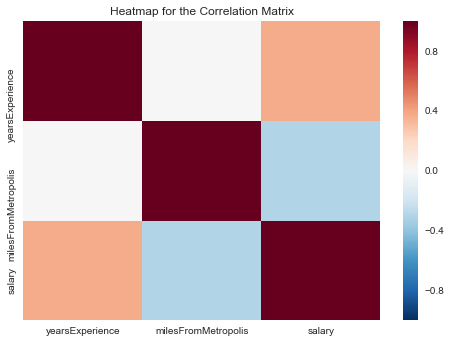

In [207]:
corr = train_data.corr()
sns.heatmap(corr,
           xticklabels = corr.columns.values,
           yticklabels = corr.columns.values)
plt.title('Heatmap for the Correlation Matrix')
# corr
plt.show()

## Multicollinearity

In [208]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = train_data[['salary','yearsExperience','milesFromMetropolis']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,4.979126,salary
1,4.443440,yearsExperience
2,2.597275,milesFromMetropolis


## Create Dummy Variables

In [345]:
train_data = pd.get_dummies(train_data, drop_first=True)
train_data.head(5)

,yearsExperience,milesFromMetropolis,salary,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,...,industry_SERVICE,industry_WEB,profile_Drop Out,profile_Executives,profile_Freshers,profile_Management,experience_buckets_10-15,experience_buckets_15-20,experience_buckets_5-10,experience_buckets_>20
0,10,83,130,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,3,73,101,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,10,38,137,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,8,17,142,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
4,8,16,163,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0


In [353]:
variables = train_data.drop(['salary'],axis=1)
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,11.147089,yearsExperience
1,3.771917,milesFromMetropolis
2,1.834861,jobType_CFO
3,1.840979,jobType_CTO
4,2.284390,jobType_JANITOR
5,2.313115,jobType_JUNIOR
6,2.236892,jobType_MANAGER
7,2.233860,jobType_SENIOR
8,1.829604,jobType_VICE_PRESIDENT
9,3.221190,degree_DOCTORAL


In the row 19, looks like the major_NONE variable has high VIF and its better to drop it.
In the field Major - None can be missing entry or the person might not have a Major. Nonetheless, 
in the benefit of doubt I will get rid of this variable.

In [212]:
variables = train_data.drop(['degree_NONE','salary'],axis=1)
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,3.299691,yearsExperience
1,3.415617,milesFromMetropolis
2,1.638655,jobType_CFO
3,1.642521,jobType_CTO
4,1.679232,jobType_JANITOR
5,1.638306,jobType_JUNIOR
6,1.639055,jobType_MANAGER
7,1.645598,jobType_SENIOR
8,1.641902,jobType_VICE_PRESIDENT
9,1.650307,degree_DOCTORAL


 All the VIF values look reasonable now and let's go ahead and drop the major_NONE value

In [330]:
train_data = train_data.drop(['major_NONE','degree_NONE'],axis=1)

In [271]:
train_data.columns

Index(['yearsExperience', 'milesFromMetropolis', 'salary', 'jobType_CFO',
       'jobType_CTO', 'jobType_JANITOR', 'jobType_JUNIOR', 'jobType_MANAGER',
       'jobType_SENIOR', 'jobType_VICE_PRESIDENT', 'degree_DOCTORAL',
       'degree_HIGH_SCHOOL', 'degree_MASTERS', 'degree_NONE',
       'industry_EDUCATION', 'industry_FINANCE', 'industry_HEALTH',
       'industry_OIL', 'industry_SERVICE', 'industry_WEB'],
      dtype='object')

### ---- 5 Establish a baseline ----

 ## Train Test Split

In [346]:
targets = train_data['salary']
inputs = train_data.drop(['salary'],axis = 1)

In [347]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(inputs)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [348]:
inputs_scaled = scaler.transform(inputs)

In [349]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size = 0.2, random_state = 4)

## Create Regression

In [350]:
reg = LinearRegression()
reg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [351]:
y_hat = reg.predict(x_train)

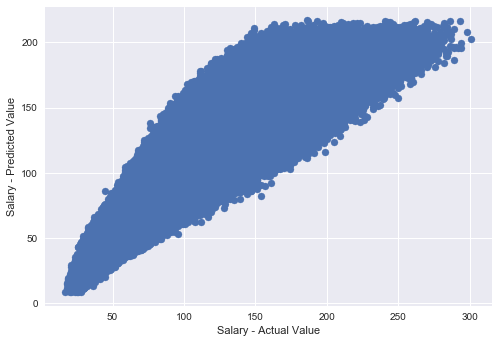

In [278]:
plt.scatter(y_train,y_hat)
plt.xlabel('Salary - Actual Value')
plt.ylabel('Salary - Predicted Value')
plt.show()

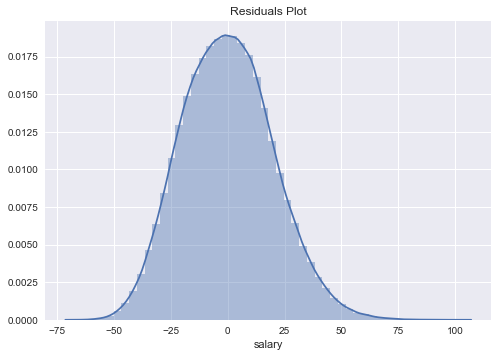

In [279]:
sns.distplot(y_train - y_hat)
plt.title("Residuals Plot")
plt.show()

In [280]:
reg.score(x_train,y_train)

0.73235830385808076

In [352]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train, y_hat)

365.38674082524346

In [169]:
reg.intercept_

4.7602867611338757

In [170]:
reg_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

,Features,Weights
0,yearsExperience,0.018430
1,milesFromMetropolis,-0.003599
2,jobType_CFO,-0.071220
3,jobType_CTO,-0.070912
4,jobType_JANITOR,-0.662240
5,jobType_JUNIOR,-0.438733
6,jobType_MANAGER,-0.237479
7,jobType_SENIOR,-0.332199
8,jobType_VICE_PRESIDENT,-0.151296
9,degree_DOCTORAL,0.118102


## Testing

In [171]:
y_hat_test = reg.predict(x_test)

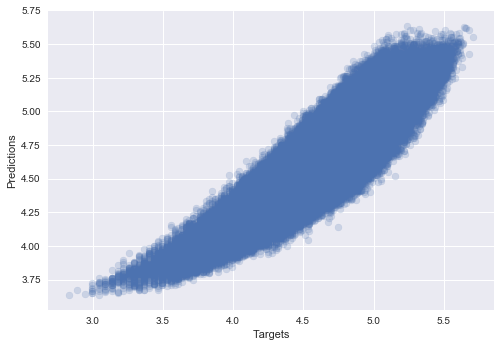

In [173]:
plt.scatter(y_test,y_hat_test,alpha=0.2)
plt.xlabel('Targets')
plt.ylabel('Predictions')
plt.show()

In [175]:
df_pf = pd.DataFrame(np.exp(y_hat_test),columns=['Prediction'])
df_pf.head(5)

,Prediction
0,115.078595
1,219.669980
2,78.707957
3,181.065391
4,108.129612


In [178]:
y_test = y_test.reset_index(drop=True)
df_pf['Target'] = np.exp(y_test)
df_pf.head(5)

,Prediction,Target
0,115.078595,143.0
1,219.669980,235.0
2,78.707957,113.0
3,181.065391,211.0
4,108.129612,134.0


In [183]:
mean_squared_error(df_pf['Target'], df_pf['Prediction'])

422.04429176565282

## Ridge Regression

In [338]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 1.0)
ridge_reg.fit(x_train,y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [339]:
y_r_hat = ridge_reg.predict(x_train)

In [340]:
mean_squared_error(y_train, y_r_hat)

366.60207722623795

### ---- 6 Hypothesize solution ----

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [15]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [1]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [16]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data